In [10]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import math
import glob
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, ShuffleSplit, LearningCurveDisplay
from sklearn import svm
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, classification_report

plt.style.use('default')
%matplotlib inline

In [2]:
# Загрузка матрицы признаков
feature_matrix =  pd.read_csv('feature_matrix_128.csv', na_values=["?"])
total_matrix = feature_matrix.copy()

total_matrix = feature_matrix.drop(columns = ['Unnamed: 0'])
total_matrix.head()

,Ax_MAV,Ax_CD,Ax_MAX,Ax_MIN,Ax_INIT,Ax_FNL,Ay_MAV,Ay_CD,Ay_MAX,Ay_MIN,...,RF_IEMG,RF_MAV,RF_LOG,RF_WL,RF_ACC,RF_DASDV,RF_ZC,RF_WAMP,RF_MYOP,Mode
0,-0.082788,0.194516,0.098621,-0.553145,-0.548947,-0.006729,0.193257,0.105025,0.482086,0.086829,...,0.659565,0.002199,0.057953,0.369797,0.001233,0.001564,52.0,0.0,0.0,0.0
1,-0.147134,0.218421,0.104413,-0.572925,-0.035088,0.104413,0.229532,0.130144,0.504380,0.085965,...,0.584493,0.001948,0.056085,0.381330,0.001271,0.001618,64.0,0.0,0.0,0.0
2,-0.095318,0.186721,0.104413,-0.572925,0.038609,-0.461041,0.214915,0.111148,0.504380,0.085965,...,0.543723,0.001812,0.054427,0.403360,0.001345,0.001724,74.0,0.0,0.0,0.0
3,-0.072635,0.191764,0.104413,-0.585118,-0.343078,-0.001161,0.194778,0.117547,0.532462,0.081685,...,0.564877,0.001883,0.055629,0.378346,0.001261,0.001626,59.0,0.0,0.0,0.0
4,-0.164038,0.216013,0.100683,-0.585118,-0.002821,-0.013294,0.248497,0.134200,0.532462,0.075260,...,0.543924,0.001813,0.054203,0.387581,0.001292,0.001632,61.0,0.0,0.0,0.0


In [3]:
x_raw = total_matrix.copy()
y = x_raw['Mode']
x_raw = x_raw.copy().drop(columns=['Mode'])
rus = RandomUnderSampler()
x_raw, y = rus.fit_resample(x_raw, y)
print(x_raw[y==0].shape)
print(x_raw[y==1].shape)

(3585, 92)
(3585, 92)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(x_raw, y, test_size=0.2, random_state=42)

In [5]:
normalizer1 = preprocessing.StandardScaler()
X_train = pd.DataFrame(normalizer1.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(normalizer1.fit_transform(X_test), columns=X_test.columns)

In [6]:
clf_svm = svm.SVC(kernel = "poly", C = 0.01, gamma = 0.1)
clf_svm.fit(X_train, y_train)

SVC(C=0.01, gamma=0.1, kernel='poly')

In [10]:
y_pred = clf_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9041641761307033


In [8]:
target_names = ['Sitting', 'Level ground walking', 'Ramp ascent', 'Ramp descent', 'Stair ascent', 'Stair descent', 'Standing']
print(classification_report(y_test, y_pred, digits = 3))
cm = confusion_matrix(y_test, y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

NameError: name 'y_pred' is not defined

NameError: name 'cm' is not defined

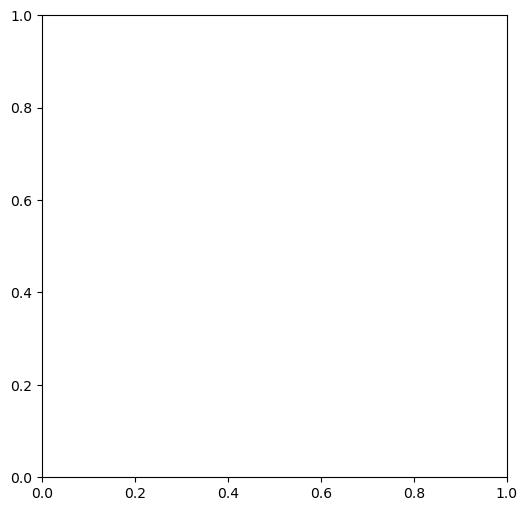

In [9]:
classes = ['Сидение', 'Ходьба по ровной поверхности', 'Подъем по рампе', 'Спуск по рампе', 'Подъем по лестнице', 'Спуск по лестнице', 'Стояние']
fig, ax = plt.subplots(figsize=(6,6))  
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d")
# labels, title and ticks
ax.set_xlabel('Предсказанные классы')
ax.set_ylabel('Реальные классы') 
ax.set_title('Матрица ошибок') 
ax.xaxis.set_ticklabels(classes,rotation=90)
ax.yaxis.set_ticklabels(classes,rotation=0)

In [10]:
c = list([1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3])
gammas = list([0.1, 1, 10, 100])
param_grid = dict(C=c, gamma=gammas)
grid = GridSearchCV(clf_svm, param_grid, cv=10, n_jobs=3, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'C': 0.01, 'gamma': 0.1}


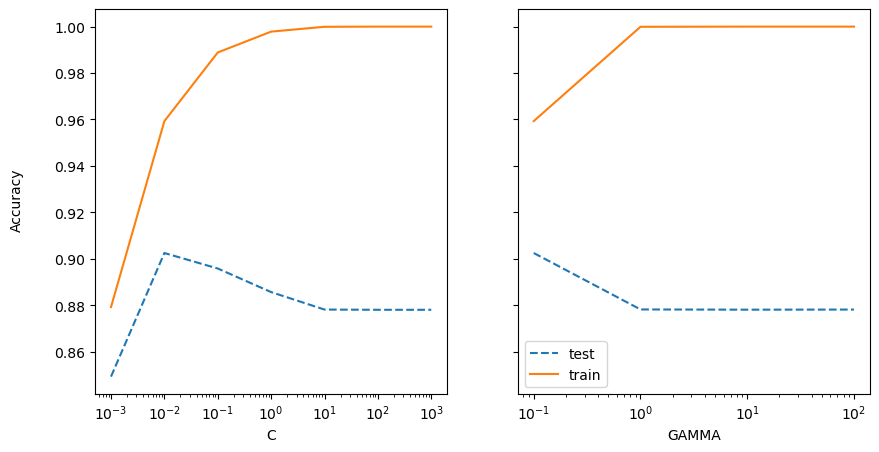

In [31]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(10,5))
    plt.xscale("log")
    fig.text(0.04, 0.5, 'Accuracy', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        #e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        #e_2 = np.array(stds_train[best_index])
        plt.xscale("log")
        ax[i].plot(x, y_1,linestyle='--', label='test')
        plt.xscale("log")
        ax[i].plot(x, y_2,linestyle='-',label='train' )
        plt.xscale("log")
        ax[i].set_xlabel(p.upper())
        ax[i].set_xscale("log")

    plt.legend()
    plt.show()

plot_search_results(grid)

In [ ]:
## Ploting results
    f
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x_1 = np.array(0:100:1)
        y_1 = np.array(means_test[best_index])
        #e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        #e_2 = np.array(stds_train[best_index])
        ax[i].plot(x, y_1,linestyle='--', label='test')
        plt.xscale("log")
        ax[i].plot(x, y_2,linestyle='-',label='train' )
        plt.xscale("log")
        ax[i].set_xlabel(p.upper())
        plt.xscale("log")

    plt.legend()
    plt.show()


In [27]:
x_1 = np.array(range(0,101))
x_1

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

Text(0.04, 0.5, 'Accuracy')

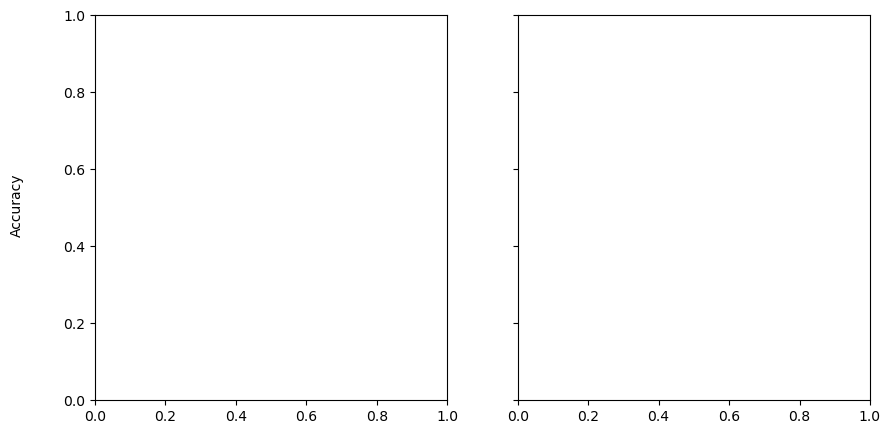

In [28]:
results = grid.cv_results_
means_test = results['mean_test_score']
stds_test = results['std_test_score']
means_train = results['mean_train_score']
stds_train = results['std_train_score']



x_1 = np.array(range(0,101))
x_2 = np.array(range(-10,1000))
y_1 = np.array(means_test[best_index])
y_2 = np.array(means_train[best_index])


fig, ax = plt.subplots(1,2,sharex='none', sharey='all',figsize=(10,5))
fig.text(0.04, 0.5, 'Accuracy', va='center', rotation='vertical')

